In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
from sklearn.decomposition import PCA
import argparse
import pandas as pd

import sys  
sys.path.insert(1, '/home/stdi2687/gnss-leo-data/scripts')

from feature_extract_util import *

# ML Classifier Pipeline
Notebook to extract labeled feature sets and train a ml models

1. read data/feature_sets into dataframe
2. select features of interest/non interest
3. map labels (Iono, Disturbance, Quiescent)
4. generate new Feature and Target vectors
5. Split into testing/training
6. Build models

In [2]:
label_df=pd.read_pickle('../data/converted_labels.pkl')
label_df_t=label_df[label_df["labeled?"]==True]
fdf_li=[]
for i,row in enumerate(label_df_t.Filename):
    #print(row['c1'], row['c2'])
    fn="../data/feature_sets/%s.pkl" %row[7:-8]
    
    try:
        fdf=pd.read_pickle(fn)
        if fdf.shape[1]==64:
            fdf_li+=[fdf]
        else:
            print(fn, fdf.shape[1])
        #print(i)
    except:
        pass
full_fdf=pd.concat(fdf_li, axis=0, ignore_index=True)

../data/feature_sets/2023.144.103.21.01.R05.SC001_0001.pkl 63


In [ ]:
# comms link df
label_df=pd.read_pickle('../data/converted_label_comms.pkl')
label_df_t=label_df[label_df["labeled?"]==True]
fdf_li=[]
for i,row in enumerate(label_df_t.Filename):
    #print(row['c1'], row['c2'])
    fn="../data/feature_sets/%s.pkl" %row
    
    try:
        fdf=pd.read_pickle(fn)
        if fdf.shape[1]==64:
            fdf_li+=[fdf]
        else:
            print(fn, fdf.shape[1])
        #print(i)
    except:
        pass
comms_fdf=pd.concat(fdf_li, axis=0, ignore_index=True)

In [ ]:
# merge FDFs!

In [3]:
full_fdf['y_'].value_counts()

3     6387
9     2888
1      232
8      160
5       74
10      73
2       31
Name: y_, dtype: int64

In [146]:
len(y_test)

4810

In [147]:
len(y_train)

4810


1. ie = 1 = e region ionospheric scintillation
2. if = 2 = f region is
3. n =  3 = NO disturbance
4. o =  4 = oscillator anomoly
5. r1 =  5 = L1 rfi
6. r2 = 6 = L2 rfi
7. r = 7 = L1 + L2 RFI
8. a = 8 = suspected tracking/processing artifact
9. l = 9 = low SNR
10. d = 10 = unknown disturbance

class_map_binary:
* 1 = Iono (1,2)
* 0 = Not iono

class_map_multi:
* 1 = Iono (1,2)
* 0 = other disturbance (4,5,6,7,8,10)
* 3 = quiescent (3)
* 2 = lowsnr (9)

In [60]:
def class_map_binary(y):
    y_new=np.empty(len(y))
    y_new[y==1]=1
    y_new[y==2]=1
    y_new[y==3]=0
    y_new[y==4]=0
    y_new[y==5]=0
    y_new[y==6]=0
    y_new[y==7]=0
    y_new[y==8]=0
    y_new[y==9]=0
    y_new[y==10]=0
    return y_new

def class_map_multi(y):
    y_new=np.empty(len(y))
    y_new[y==1]=1
    y_new[y==2]=1
    y_new[y==3]=3
    y_new[y==4]=0
    y_new[y==5]=0
    y_new[y==6]=0
    y_new[y==7]=0
    y_new[y==8]=0
    y_new[y==9]=2
    y_new[y==10]=0
    return y_new

def get_meta_drop(df):
    times=df['time'].values
    lats=df["lat_m"].values
    occ_hts=df['occheight_m'].values
    X=df.loc[:, df.columns != 'y_'].drop(columns=['time', 'lat_m','occheight_m']).values
    feature_names=df.loc[:, df.columns != 'y_'].drop(columns=['time', 'lat_m','occheight_m']).columns
    return X, feature_names, times, lats, occ_hts

def df_2_Xy(df):
    #drop_cols=['time2', 'rfi_max','lat_m', 'lon_m', 'elevation_m', 'occheight_m','slip_L1', 'slip_L2',]
    drop_cols=[ 'rfi_max', 'spl1_2.0', 'spl1_2.3', 'spl1_2.7', 'spl1_3.0', 'spl1_3.3', 'spl1_3.7', 'spl1_4.0', 'spl1_4.3', 'spl1_4.7', 'spl1_5.0', 'spl1_5.3', 'spl1_5.7', 'spl1_6.0', 'spl1_6.3', 'spl1_6.7', 'spl1_7.0', 'spl1_7.3', 'spl1_7.7', 'spl1_8.0', 'spl1_8.3', 'spl2_2.0', 'spl2_2.3', 'spl2_2.7', 'spl2_3.0', 'spl2_3.3', 'spl2_3.7', 'spl2_4.0', 'spl2_4.3', 'spl2_4.7', 'spl2_5.0', 'spl2_5.3', 'spl2_5.7', 'spl2_6.0', 'spl2_6.3', 'spl2_6.7', 'spl2_7.0', 'spl2_7.3', 'spl2_7.7', 'spl2_8.0', 'spl2_8.3', 'time2', 'lat_m', 'lon_m', 'elevation_m', 'occheight_m', 'slip_L1', 'slip_L2']
    drop_cols=[ 'rfi_max', 'spl1_2.0', 'spl1_2.3', 'spl1_2.7', 'spl1_3.0', 'spl1_3.3', 'spl1_3.7', 'spl1_4.0', 'spl1_4.3', 'spl1_4.7', 'spl1_5.0', 'spl1_5.3', 'spl1_5.7', 'spl1_6.0', 'spl1_6.3', 'spl1_6.7', 'spl1_7.0', 'spl1_7.3', 'spl1_7.7', 'spl1_8.0', 'spl1_8.3', 'spl2_2.0', 'spl2_2.3', 'spl2_2.7', 'spl2_3.0', 'spl2_3.3', 'spl2_3.7', 'spl2_4.0', 'spl2_4.3', 'spl2_4.7', 'spl2_5.0', 'spl2_5.3', 'spl2_5.7', 'spl2_6.0', 'spl2_6.3', 'spl2_6.7', 'spl2_7.0', 'spl2_7.3', 'spl2_7.7', 'spl2_8.0', 'spl2_8.3', 'time2', 'lon_m', 'elevation_m', 'slip_L1', 'slip_L2']
    df=df.drop(columns=drop_cols)

    #Drop low SNR?
    #if "y_" in df:
    #    df = df[df["y_"] != 9]

    # Drop nans, inf, etc
    df=df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

    times=df['time'].values
    lats=df["lat_m"].values
    occ_hts=df['occheight_m'].values
    X=df.loc[:, df.columns != 'y_'].drop(columns=['time', 'lat_m','occheight_m']).values
    feature_names=df.loc[:, df.columns != 'y_'].drop(columns=['time', 'lat_m','occheight_m']).columns
    if "y_" in df:
        y_og=df["y_"]
        y_=class_map_binary(y_og)
        #y_=y_og
    else:
        y_=np.empty(X.shape[1])*np.nan

    return X, y_, times, lats, occ_hts, feature_names

In [96]:
full_fdf

,time,std_l2ol1,ratio_l2ol1,snr_l1_std,snr_l2_std,snr_l1_range,snr_l2_range,rfi_max,coeffpca0,coeffpca1,...,s4_max_L1,sigphi_max_L1,sigphi_max_L2,lat_m,lon_m,elevation_m,occheight_m,slip_L1,slip_L2,y_
0,1.368928e+09,1.195634,0.984541,1.293613,1.273649,13.508016,13.527730,0.000040,-0.627244,-0.778823,...,0.416775,0.041900,0.054318,28.757234,39.697388,-19.471120,79.950910,0.0,0.0,9
1,1.368928e+09,1.099459,0.801428,1.314884,1.099929,8.563260,15.660623,0.000100,-0.659855,-0.751393,...,0.417511,0.042990,0.054275,29.708831,39.927164,-18.549674,115.469803,0.0,0.0,9
2,1.368928e+09,0.808993,0.363675,1.453694,0.771614,10.254964,9.575202,0.000165,0.845310,0.534276,...,0.306012,0.036844,0.018936,30.660115,40.160123,-17.624606,149.437231,0.0,0.0,9
3,1.368928e+09,0.474674,0.084108,1.723766,0.922887,13.041211,12.002249,0.000138,0.994290,0.106708,...,0.307104,0.057685,0.035955,31.611070,40.396452,-16.695877,181.826057,0.0,0.0,9
4,1.368928e+09,0.455076,-0.057902,NaN,0.915059,inf,8.266637,0.000071,-0.997372,0.072449,...,0.319351,0.065079,0.036055,32.561681,40.636350,-15.763444,212.609043,0.0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8478,1.369007e+09,1.030192,1.011011,0.209479,0.341596,1.371181,2.328268,0.000028,-0.696312,-0.717740,...,0.165132,0.017542,0.017855,52.258626,78.877645,-14.010695,256.571836,0.0,0.0,3
8479,1.369007e+09,1.015877,0.993634,0.216113,0.365668,1.151321,2.177353,0.000161,-0.701390,-0.712778,...,0.173108,0.016465,0.016892,53.195066,79.286299,-15.007631,226.501233,0.0,0.0,5
8480,1.369007e+09,1.033945,1.014508,0.350114,0.359372,2.039790,2.306500,0.000164,-0.694979,-0.719030,...,0.171657,0.017594,0.017923,54.130338,79.710361,-16.000195,194.583653,0.0,0.0,5
8481,1.369007e+09,1.024151,0.999968,0.193811,0.360424,1.025758,2.370027,0.000087,-0.698414,-0.715694,...,0.165834,0.018204,0.018694,55.064359,80.151071,-16.988453,160.852662,0.0,0.0,3


In [61]:
X, y, times, lats, occ_hts, feature_names =df_2_Xy(full_fdf)


In [139]:
feature_names

Index(['std_l2ol1', 'ratio_l2ol1', 'snr_l1_std', 'snr_l2_std', 'snr_l1_range',
       'snr_l2_range', 'coeffpca0', 'coeffpca1', 'explpca0', 'explpca1',
       's4_max_L1', 's4_max_L1', 'sigphi_max_L1', 'sigphi_max_L2'],
      dtype='object')

In [128]:
feature_names

Index(['std_l2ol1', 'ratio_l2ol1', 'snr_l1_std', 'snr_l2_std', 'snr_l1_range',
       'snr_l2_range', 'coeffpca0', 'coeffpca1', 'explpca0', 'explpca1',
       's4_max_L1', 's4_max_L1', 'sigphi_max_L1', 'sigphi_max_L2'],
      dtype='object')

In [9]:
version="1" # what does this mean?
print(X.shape, y.shape)
from collections import Counter
print("Class numbers check")
print(Counter(y.ravel()))

#---- split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, lats_train, lats_test, hts_train, hts_test = train_test_split(X, y.ravel(), lats, occ_hts, test_size = 0.5, random_state = 20, stratify = y)

#drop low snr from training but keep for testing!
#X_train=X_train[y_train!=9]
#y_train=y_train[y_train!=9]

# map to binary classes
#y_train=class_map_binary(y_train)
#y_test=class_map_binary(y_test)

def rf_model(X_train, y_train):
    #--- train models
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state = 42))
    ])
    parameteres = { 
        'clf__n_estimators': [1, 10, 100],
        'clf__max_features': ['auto', 'sqrt', 'log2'],
        'clf__max_depth' : [1,10,100, 1000],
        #'clf__criterion' : ['gini', 'entropy'],
        'clf__class_weight' : [None, 'balanced', 'balanced_subsample']
    }
    from sklearn.model_selection import GridSearchCV
    model = GridSearchCV(pipeline, param_grid = parameteres, cv = 5, n_jobs=20, scoring="f1")
    model.fit(X_train, y_train)

    print("\nBest: %f using %s" % (model.best_score_, model.best_params_))
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("      %f (%f) with: %r" % (mean, stdev, param))

    #-- Save model
    from joblib import dump, load
    #dump(model, '../models/%s_rf-model.joblib' %version)
    
    return model

def xgb_model(X_train, y_train):
    #--- train model
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from xgboost import XGBClassifier

    estimator = XGBClassifier(
        objective= 'binary:logistic',
        nthread=4,
        seed=42
    )
    parameters = {
        'max_depth': range (2, 10, 1),
        'n_estimators': range(60, 220, 40),
        'learning_rate': [0.1, 0.01, 0.05]
    }
    from sklearn.model_selection import GridSearchCV
    model = GridSearchCV(estimator, param_grid = parameters, cv = 5, n_jobs=20, scoring="f1")
    model.fit(X_train, y_train)

    print("\nBest: %f using %s" % (model.best_score_, model.best_params_))
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("      %f (%f) with: %r" % (mean, stdev, param))

    #-- Save model
    from joblib import dump, load
    #dump(model, '../models/%s_xgb-model.joblib' %version)

    return model

def svc_model(X_train, y_train):
    from sklearn.svm import SVC 
    from sklearn.model_selection import GridSearchCV 
  
    # defining parameter range 
    param_grid = {'C': [0.1, 1, 10, 100, 1000],  
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                'kernel': ['rbf']}  
    
    model = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = 5, n_jobs=20, scoring="f1") 
    # fitting the model for grid search 
    model.fit(X_train, y_train)
    print("\nBest: %f using %s" % (model.best_score_, model.best_params_))
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("      %f (%f) with: %r" % (mean, stdev, param))

    #-- Save model
    from joblib import dump, load
    #dump(model, '/home/kawu4468-copy/trained_models/rf-model.joblib')

    return model
  
rf_model=rf_model(X_train, y_train)
xgb_model=xgb_model(X_train, y_train)
svc_model=svc_model(X_train, y_train)

for model in [rf_model, xgb_model, svc_model]:
    #--- test model
    y_pred = model.predict(X_test)

    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import precision_recall_fscore_support
    print("\nConfusion matrix")
    print(confusion_matrix(y_test, y_pred))
    y = y[~np.isnan(X).any(axis=1)]
    X = X[~np.isnan(X).any(axis=1)]
    print(X.shape, y.shape)
    print("\nResult")
    print(classification_report(y_test, y_pred))

    print(precision_recall_fscore_support(y_test, y_pred))

(9620, 14) (9620,)
Class numbers check
Counter({3: 6385, 9: 2695, 1: 230, 8: 138, 5: 74, 10: 67, 2: 31})

Best: 0.499518 using {'clf__class_weight': 'balanced_subsample', 'clf__max_depth': 10, 'clf__max_features': 'auto', 'clf__n_estimators': 100}
      0.000000 (0.000000) with: {'clf__class_weight': None, 'clf__max_depth': 1, 'clf__max_features': 'auto', 'clf__n_estimators': 1}
      0.000000 (0.000000) with: {'clf__class_weight': None, 'clf__max_depth': 1, 'clf__max_features': 'auto', 'clf__n_estimators': 10}
      0.000000 (0.000000) with: {'clf__class_weight': None, 'clf__max_depth': 1, 'clf__max_features': 'auto', 'clf__n_estimators': 100}
      0.000000 (0.000000) with: {'clf__class_weight': None, 'clf__max_depth': 1, 'clf__max_features': 'sqrt', 'clf__n_estimators': 1}
      0.000000 (0.000000) with: {'clf__class_weight': None, 'clf__max_depth': 1, 'clf__max_features': 'sqrt', 'clf__n_estimators': 10}
      0.000000 (0.000000) with: {'clf__class_weight': None, 'clf__max_depth': 

In [133]:
# Determine Optimal thresholds for S4/Sig Phi based upon training

#S4
for thresh in np.arange(0.1,1,.1):
    y_pred_thresh_s4=np.zeros(len(X_train))
    y_pred_thresh_s4[(X_train[:,-4]>thresh)|(X_train[:,-3]>thresh)]=1
    precision, recall, fscore, support=precision_recall_fscore_support(y_train, y_pred_thresh_s4)
    print(thresh, fscore)

#Sig Phi
for thresh1 in np.arange(0.03,.08,.01):
    for thresh2 in np.arange(0.01,.08,.01):
        y_pred_thresh_sig=np.zeros(len(X_train))
        y_pred_thresh_sig[(X_train[:,-2]>thresh1)|(X_train[:,-1]>thresh2)]=1
        precision, recall, fscore, support=precision_recall_fscore_support(y_train, y_pred_thresh_sig)
        print(thresh1, thresh2, fscore)

0.1 [0.13101658 0.05679601]
0.2 [0.78006472 0.10343008]
0.30000000000000004 [0.92064575 0.15291262]
0.4 [0.95851528 0.17391304]
0.5 [0.97468897 0.2027027 ]
0.6 [0.98212386 0.24324324]
0.7000000000000001 [0.98431871 0.18681319]
0.8 [0.98572184 0.18181818]
0.9 [0.98532362 0.06711409]
0.03 0.01 [0.15199368 0.05665349]
0.03 0.02 [0.68675543 0.10060362]
0.03 0.03 [0.91485423 0.24590164]
0.03 0.04 [0.94816971 0.32605531]
0.03 0.05 [0.95596229 0.34380165]
0.03 0.060000000000000005 [0.96057427 0.36814159]
0.03 0.06999999999999999 [0.96240767 0.37887067]
0.03 0.08 [0.96343612 0.38518519]
0.04 0.01 [0.15199368 0.05665349]
0.04 0.02 [0.68693946 0.10064412]
0.04 0.03 [0.91497976 0.24615385]
0.04 0.04 [0.94969819 0.33234421]
0.04 0.05 [0.9632967  0.35769231]
0.04 0.060000000000000005 [0.97374702 0.39800995]
0.04 0.06999999999999999 [0.97646297 0.39106145]
0.04 0.08 [0.97756687 0.40229885]
0.05 0.01 [0.15199368 0.05665349]
0.05 0.02 [0.68693946 0.10064412]
0.05 0.03 [0.91497976 0.24615385]
0.05 0.04

In [134]:
# Make a plot to compare model testing performance with thresholds

#threshold
y_pred_thresh_s4=np.zeros(len(X_test))
y_pred_thresh_s4[(X_test[:,-4]>0.6)|(X_test[:,-3]>0.6)]=1

y_pred_thresh_sig=np.zeros(len(X_test))
y_pred_thresh_sig[(X_test[:,-2]>0.07)|(X_test[:,-2]>0.06)]=1

y_pred_rf = rf_model.predict(X_test)
y_pred_xgb=xgb_model.predict(X_test) 
y_pred_svc=svc_model.predict(X_test)

from sklearn.metrics import confusion_matrix
def metrics_confusion(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    return TPR, FPR, ACC

# need to do this for L1 and L2?

met_li=[]
for name,y_metric in zip(["RF", "XGB", "SVC", "S4","Sigma Phi"],[y_pred_rf, y_pred_xgb, y_pred_svc, y_pred_thresh_s4, y_pred_thresh_sig]):
    precision, recall, fscore, support=precision_recall_fscore_support(y_test, y_metric)
    print(fscore)
    met_li+=[np.array([[name, "Precision", precision[1]],
                       [name, "Recall", recall[1]], 
                       [name, "F1", fscore[1]]])]

    cm=confusion_matrix(y_test, y_metric)
    TPR, FPR, ACC=metrics_confusion(cm)
    print(TPR, FPR, ACC)


[0.98419185 0.54205607]
[0.97777778 0.66923077] [0.33076923 0.02222222] [0.96943867 0.96943867]
[0.99107901 0.58823529]
[0.99700855 0.46153846] [0.53846154 0.00299145] [0.98253638 0.98253638]
[0.99043977 0.5631068 ]
[0.99615385 0.44615385] [0.55384615 0.00384615] [0.98128898 0.98128898]
[0.9798872  0.15246637]
[0.98376068 0.13076923] [0.86923077 0.01623932] [0.96070686 0.96070686]
[0.98320578 0.25471698]
[0.98824786 0.20769231] [0.79230769 0.01175214] [0.96715177 0.96715177]


In [135]:
met_li

[array([['RF', 'Precision', '0.45549738219895286'],
        ['RF', 'Recall', '0.6692307692307692'],
        ['RF', 'F1', '0.5420560747663551']], dtype='<U32'),
 array([['XGB', 'Precision', '0.8108108108108109'],
        ['XGB', 'Recall', '0.46153846153846156'],
        ['XGB', 'F1', '0.5882352941176471']], dtype='<U32'),
 array([['SVC', 'Precision', '0.7631578947368421'],
        ['SVC', 'Recall', '0.4461538461538462'],
        ['SVC', 'F1', '0.5631067961165048']], dtype='<U32'),
 array([['S4', 'Precision', '0.1827956989247312'],
        ['S4', 'Recall', '0.13076923076923078'],
        ['S4', 'F1', '0.15246636771300448']], dtype='<U32'),
 array([['Sigma Phi', 'Precision', '0.32926829268292684'],
        ['Sigma Phi', 'Recall', '0.2076923076923077'],
        ['Sigma Phi', 'F1', '0.2547169811320755']], dtype='<U32')]

In [136]:
df=pd.DataFrame(np.concatenate(met_li), columns=["Model", "Metric", "Score"])

In [137]:
df["Score"]=df.Score.astype(np.float16)

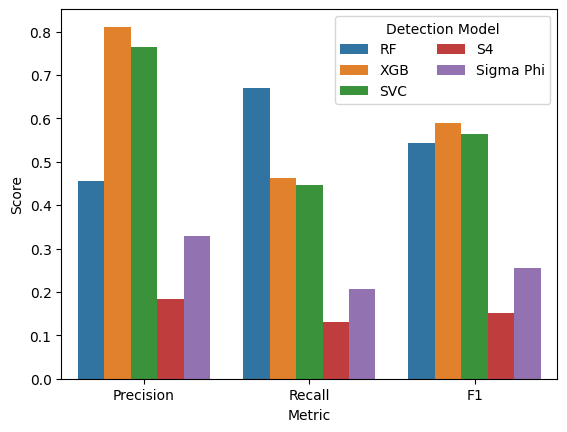

In [143]:
import seaborn as sns

fig,ax=plt.subplots()
ax=sns.barplot(df, x="Metric", y="Score", hue="Model")
ax.legend(loc='upper right',ncol=2, title="Detection Model")
plt.savefig("../figures/compare_f1.png", dpi=300)

In [59]:
xgb_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=180,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, ...)

<AxesSubplot:>

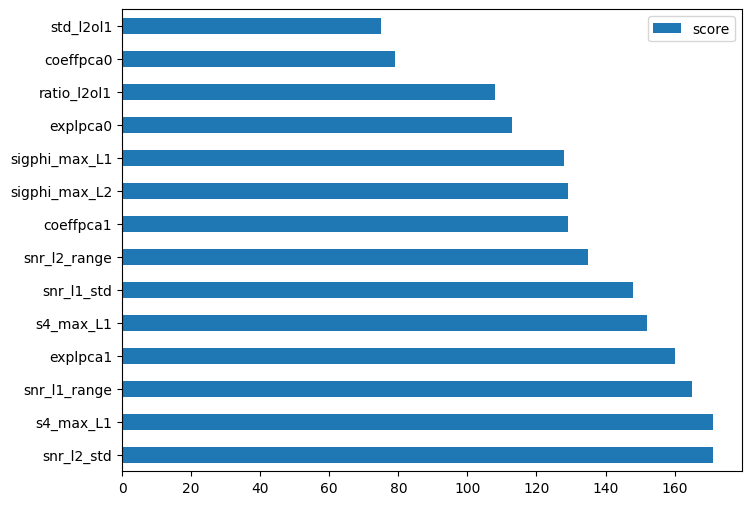

In [67]:
#Retrain Model on Entire Dataset
#XGB FEATURE IMPORTANCE

from xgboost import XGBClassifier
# create model instance
bst = XGBClassifier(n_estimators=xgb_model.best_estimator_.n_estimators, max_depth=xgb_model.best_estimator_.max_depth, learning_rate=xgb_model.best_estimator_.learning_rate, objective='binary:logistic')
# fit model
bst.fit(X, y)


feature_important = bst.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
keys = feature_names
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (8,6)) ## plot top 40 features

In [84]:
# RANDOM FOREST FEATURE IMPORTANCE
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
import time
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    xgb_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 0.913 seconds


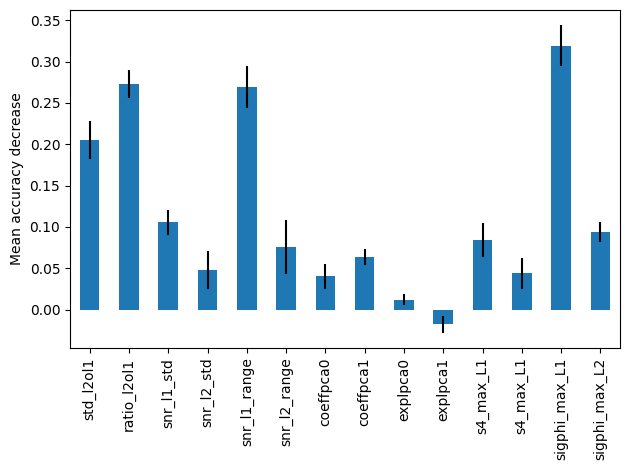

In [148]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
#ax.set_title("Feature importances using permutation on full XGB model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.savefig("../figures/xgb_feat_import.png", dpi=300)
plt.show()


In [87]:
#Evaluate results by region
# 
for lat_n,lat_r in zip(["Low", "Mid", "High"],[(0,30), (30,60), (60,90)]):
    idx=(np.abs(lats_test)>lat_r[0]) & (lat_r[1]>=np.abs(lats_test))
    precision, recall, fscore, support=precision_recall_fscore_support(y_test[idx], y_pred_xgb[idx])
    print(precision, recall, fscore, support)

for ht_n,ht_r in zip(["E", "F"],[(90,140), (140,500)]):
    idx=(np.abs(hts_test)>ht_r[0]) & (ht_r[1]>=np.abs(hts_test))
    precision, recall, fscore, support=precision_recall_fscore_support(y_test[idx], y_pred_xgb[idx])
    print(precision, recall, fscore, support)

[0.98313878 0.92857143] [0.99868248 0.5       ] [0.99084967 0.65      ] [1518   52]
[0.98441558 0.82142857] [0.99736842 0.43396226] [0.99084967 0.56790123] [1900   53]
[0.98896769 0.61111111] [0.99445325 0.44      ] [0.99170288 0.51162791] [1262   25]
[0.82432432 0.875     ] [0.96825397 0.51851852] [0.89051095 0.65116279] [189  81]
[0.99571203 0.5       ] [0.99864192 0.24      ] [0.99717482 0.32432432] [4418   25]


In [90]:
for lat_n,lat_r in zip(["Low", "Mid", "High"],[(0,30), (30,60), (60,90)]):
    for ht_n,ht_r in zip(["E", "F"],[(90,140), (140,500)]):
        idx=(np.abs(lats_test)>lat_r[0]) & (lat_r[1]>=np.abs(lats_test)) & (np.abs(hts_test)>ht_r[0]) & (ht_r[1]>=np.abs(hts_test))
        precision, recall, fscore, support=precision_recall_fscore_support(y_test[idx], y_pred_xgb[idx])
        print(lat_n, ht_n, precision, recall, fscore, support)
    

Low E [0.75       0.95238095] [0.98181818 0.52631579] [0.8503937 0.6779661] [55 38]
Low F [0.997921 1.      ] [1.   0.25] [0.99895942 0.4       ] [1440    4]
Mid E [0.85526316 0.84210526] [0.95588235 0.59259259] [0.90277778 0.69565217] [68 27]
Mid F [0.99227799 0.5       ] [0.99888951 0.125     ] [0.99557277 0.2       ] [1801   16]
High E [0.86486486 0.75      ] [0.96969697 0.375     ] [0.91428571 0.5       ] [66 16]
High F [0.99829787 0.42857143] [0.99660153 0.6       ] [0.99744898 0.5       ] [1177    5]


In [105]:
l1_wl=19.05/100 #m
l2_wl=25.48/100

sig_phi_threshold_l1=15*l1_wl/360 #1 degree threshold
sig_phi_threshold_l2=15*l2_wl/360

y_pred_sig_phi_threshold=np.zeros(len(X_test))
y_pred_sig_phi_threshold[X_test[:,-2]>sig_phi_threshold_l1]=1

y_pred_sig_phi_threshold[X_test[:,-1]>sig_phi_threshold_l2]=1


In [106]:
y_pred_sig_phi_threshold.sum()

4408.0

In [82]:
y_pred.sum()

77.0

In [109]:
lv2

<xarray.Dataset>
Dimensions:       (attribute_dimension: 1, time: 367)
Coordinates:
  * time          (time) float64 8.0 9.0 10.0 11.0 ... 371.0 372.0 373.0 374.0
Dimensions without coordinates: attribute_dimension
Data variables: (12/21)
    sigma_phi_L1  (time) float64 0.008102 0.007953 0.007493 ... 0.00767 0.007935
    sigma_phi_L2  (time) float64 0.01063 0.01025 0.009651 ... 0.01463 0.01519
    slip_L1       (time) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    slip_L2       (time) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    s4_L1         (time) float64 0.119 0.1173 0.1185 ... 0.06352 0.06485 0.06456
    s4_L2         (time) float64 0.1043 0.1092 0.1082 ... 0.9362 1.036 1.178
    ...            ...
    z_GPS         (time) float64 2.164e+04 2.164e+04 ... 2.111e+04 2.111e+04
    lat           (time) float64 51.88 51.82 51.76 51.69 ... 28.76 28.7 28.64
    lon           (time) float64 -54.21 -54.24 -54.26 ... -61.14 -61.16 -61.17
    gast1         (attribute_dimension) float64 1.824
    gast2         (attribute_dimension) float64 1.85
    leapsec       (attribute_dimension) float64 18.0
Attributes: (12/72)
    Conventions:                CF-1.6
    Version:                    $Id$
    alt_s4max_L1:               435.9394982051699
    alt_s4max_L2:               435.76097759304685
    alt_sigmaphimax_L1:         435.929329394874
    alt_sigmaphimax_L2:         435.929329394874
    ...                         ...
    sigmaphimin_L2:             0.0030882556457072496
    startTime:                  1369061184.0
    stopTime:                   1369061558.0
    subver:                     0001.0001
    timeOfProcessing:           2023.238.18.07.50 GPS time
    year:                       2023

In [182]:
sample='2023.143.125.12.01.R24.SC001_0001'
sample='2023.143.125.23.01.G12.SC001_0001'
#sample='2023.143.125.17.01.G18.SC001_0001'
#sample='2023.145.125.14.01.E09.SC001_0001' # RFI?
#sample='2023.145.125.14.01.E05.SC001_0001' #RFI
sample='2023.143.169.17.01.G18.SC001_0001'
sample='2023.143.125.17.01.R11.SC001_0001'

fn='/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/%s/scnPhs_%s.0001_nc'%(sample[:8],sample)
lv1=load_leo(fn)
fn='/media/datastore/mirror/spwxdp/repro4/spire/level2/scnLv2/%s/scnLv2_%s.0001_nc'%(sample[:8],sample)
lv2=load_leo(fn)

#plot_leo(sample, sp, lv2)
fdf=extract_fs(lv1,lv2)

In [183]:
X, y_, times, lats, occ_hts, feature_names=df_2_Xy(fdf)

In [184]:
#--- test model
y_pred = bst.predict(X)
print(y_pred)

[0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0]


In [185]:
from matplotlib.patches import Rectangle
def plot_leo_ml(sample, ds, lv2, y_pred, times):

    c=299792458 #m/s
    #iono_free=((ds.scnfreq1**2)*(c/ds['exL1'])-(ds.scnfreq2**2)*(c/ds['exL2']))/(ds.scnfreq1**2-ds.scnfreq2**2)
    
    #ku=40.3*1e16
    #dTEC=(ds['exL2']-ds['exL1'])/(ku*(1/ds.scnfreq1**2-1/ds.scnfreq2**2))
    fig,ax=plt.subplots(6, figsize=(8,8),sharex=True)
    ax[0].set_title(sample)

    for freq,snr,color in zip([1,2],['caL1Snr','pL2Snr'],['#1b9e77','#d95f02']): 
        ax[0].plot(ds[snr].time+ds.startTime, ds[snr].values, alpha=.5, color=color, label='L%s'%freq)
        ax[0].set_ylabel('SNR' "\n" '(v/v)')

        ax[1].plot(lv2['s4_L%s'%freq].time+lv2.startTime, lv2['s4_L%s'%freq].values, color=color)
        ax[1].set_ylabel('S4')
        
        #ax[1].plot(ds['raw_exL%s'%freq].time, ds['raw_exL%s'%freq].values, color=color, label='L%s'%freq)
        #ax[1].set_ylabel(r'$\delta \phi$ (cycles)')
        ax[4].plot(lv2['elevation'].time+lv2.startTime, lv2['elevation'].values, color='black')
        ax[4].set_ylabel('elevation')
        ax2=ax[4].twinx()
        ax2.plot(ds['occheight'].time+ds.startTime, ds['occheight'].values, color='tab:orange')
        ax2.set_ylabel('occ height', color='tab:orange')

            
        ax[2].plot(ds['exL%s'%freq].time+ds.startTime, ds['exL%s'%freq].values, color=color, label='L%s'%freq)
        ax[2].set_ylabel(r'$\delta \phi$' "\n" '(m)')

        ax[3].plot(lv2['sigma_phi_L%s'%freq].time+lv2.startTime, lv2['sigma_phi_L%s'%freq].values, color=color)
        ax[3].set_ylabel(r'$\sigma \phi$' "\n" '(m)')
    #ax[3].plot(dTEC.time, dTEC.values)
    
    #ax[3].set_ylabel(r'$\Delta TEC$' "\n" '(TECU)')
    
    #ax[4].plot(iono_free.time, iono_free.values)
    #ax[4].set_ylabel('iono-free' "\n" '(m)')
    ax[0].legend(ncol=2)
    '''
    ## plot ml results
    df=pd.read_pickle('/home/kawu4468-copy/data_mat/spire_iq/rf_ml_ro.pkl')
    colors=['#e7298a','#d95f02','#7570b3','#1b9e77','#1b9e77','#66a61e','#e6ab02'] ##1b9e77
    labels=['scint', 'OA', 'dual int', 'quiet', 'quiet', 'l1 int', 'l2 int']
    fn_arr='scnPhs_%s.0001_ex.mat' %sample
    df=df[df.file==fn_arr]
    print(df['sample'])
    print(df.y_pred)
    [ax[5].add_patch(Rectangle((ds.time.min()+i*15, 0), 15, 1, alpha=.75, color= ,  label=labels[y-1])) for i, y in list(zip(df['sample'], df.y_pred))]
    '''
    [ax[5].add_patch(Rectangle((i, 0), 15, 1, alpha=1, label='No Scint', color="white")) for i in times[y_pred==0]]
    [ax[5].axvline(i) for i in times]
    [ax[5].add_patch(Rectangle((i, 0), 15, 1, alpha=.75, label='Scintillation')) for i in times[y_pred>0]]
    
    handles,labels=ax[5].get_legend_handles_labels() #get existing legend item handles and labels
    by_label = dict(zip(labels, handles))
    ax[5].legend(by_label.values(), by_label.keys(), ncol=4, loc='lower left')
    ax[5].get_yaxis().set_ticks([])
    ax[5].set_ylabel('RF Class')

    ax[5].set_xlim([times.min(), times.max()])
    plt.savefig("../figures/results/%s.png" %sample, dpi=300)
    

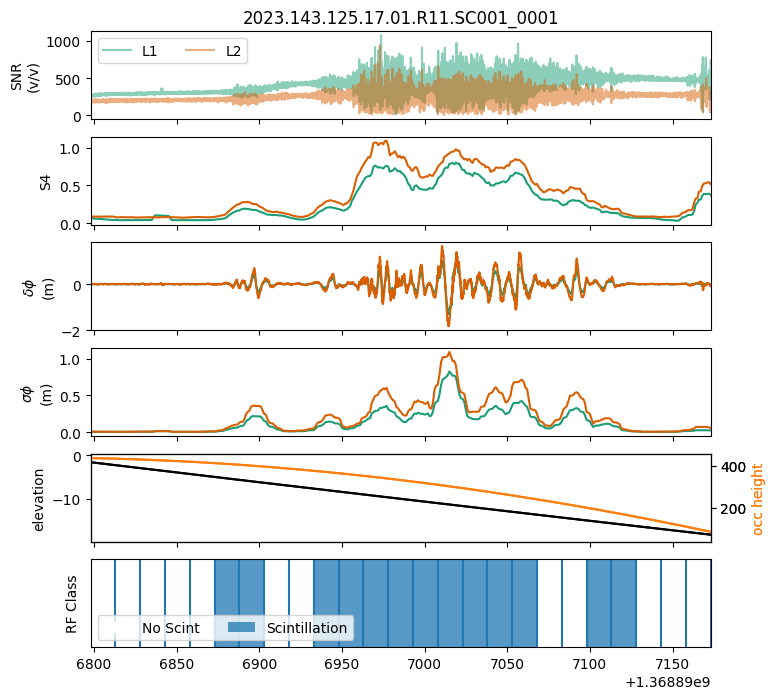

In [186]:
plot_leo_ml(sample, lv1, lv2, y_pred, times)

In [79]:
times[y_pred>0]

array([1.36891964e+09, 1.36891962e+09, 1.36891956e+09, 1.36891953e+09,
       1.36891952e+09, 1.36891949e+09, 1.36891944e+09, 1.36891941e+09,
       1.36891937e+09, 1.36891935e+09, 1.36891931e+09, 1.36891929e+09])

In [146]:
print(X.shape, y.shape)
from collections import Counter
print("Class numbers check")
print(Counter(y.ravel()))

#---- split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, lats_train, lats_test, hts_train, hts_test = train_test_split(X, y.ravel(), lats, occ_hts, test_size = 0.5, random_state = 20, stratify = y)

#drop low snr from training but keep for testing!
#X_train=X_train[y_train!=9]
#y_train=y_train[y_train!=9]

# map to binary classes
y_train=class_map_binary(y_train)
y_test=class_map_binary(y_test)

#--- train model
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state = 42))
])

estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(estimator, param_grid = parameteres, cv = 5, n_jobs=20, scoring="f1")
model.fit(X_train, y_train)

print("\nBest: %f using %s" % (model.best_score_, model.best_params_))
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
params = model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("      %f (%f) with: %r" % (mean, stdev, param))

#-- Save model
from joblib import dump, load
#dump(model, '/home/kawu4468-copy/trained_models/rf-model.joblib')

#--- test model
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
print("\nConfusion matrix")
print(confusion_matrix(y_test, y_pred))
y = y[~np.isnan(X).any(axis=1)]
X = X[~np.isnan(X).any(axis=1)]
print(X.shape, y.shape)
print("\nResult")
print(classification_report(y_test, y_pred))

print(precision_recall_fscore_support(y_test, y_pred))

(9620, 14) (9620,)
Class numbers check
Counter({3: 6385, 9: 2695, 1: 230, 8: 138, 5: 74, 10: 67, 2: 31})
[03:58:58] WARNING: ../src/learner.cc:627: 
Parameters: { "clf__max_depth", "clf__max_features", "clf__n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:58:58] WARNING: ../src/learner.cc:627: 
Parameters: { "clf__max_depth", "clf__max_features", "clf__n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:58:58] WARNING: ../src/learner.cc:627: 
Parameters: { "clf__max_depth", "clf_

y

['time', 'std_l2ol1', 'ratio_l2ol1', 'snr_l1_std', 'snr_l2_std', 'snr_l1_range', 'snr_l2_range', 'rfi_max', 'coeffpca0', 'coeffpca1', 'explpca0', 'explpca1', 'spl1_2.0', 'spl1_2.3', 'spl1_2.7', 'spl1_3.0', 'spl1_3.3', 'spl1_3.7', 'spl1_4.0', 'spl1_4.3', 'spl1_4.7', 'spl1_5.0', 'spl1_5.3', 'spl1_5.7', 'spl1_6.0', 'spl1_6.3', 'spl1_6.7', 'spl1_7.0', 'spl1_7.3', 'spl1_7.7', 'spl1_8.0', 'spl1_8.3', 'spl2_2.0', 'spl2_2.3', 'spl2_2.7', 'spl2_3.0', 'spl2_3.3', 'spl2_3.7', 'spl2_4.0', 'spl2_4.3', 'spl2_4.7', 'spl2_5.0', 'spl2_5.3', 'spl2_5.7', 'spl2_6.0', 'spl2_6.3', 'spl2_6.7', 'spl2_7.0', 'spl2_7.3', 'spl2_7.7', 'spl2_8.0', 'spl2_8.3', 'time2', 's4_max_L1', 's4_max_L1', 'sigphi_max_L1', 'sigphi_max_L2', 'lat_m', 'lon_m', 'elevation_m', 'occheight_m', 'slip_L1', 'slip_L2', 'y_']

Drop=['time', 'time2', 'lat_m', 'lon_m', 'elevation_m', 'occheight_m']

drop=[ 'rfi_max', 'spl1_2.0', 'spl1_2.3', 'spl1_2.7', 'spl1_3.0', 'spl1_3.3', 'spl1_3.7', 'spl1_4.0', 'spl1_4.3', 'spl1_4.7', 'spl1_5.0', 'spl1_5.3', 'spl1_5.7', 'spl1_6.0', 'spl1_6.3', 'spl1_6.7', 'spl1_7.0', 'spl1_7.3', 'spl1_7.7', 'spl1_8.0', 'spl1_8.3', 'spl2_2.0', 'spl2_2.3', 'spl2_2.7', 'spl2_3.0', 'spl2_3.3', 'spl2_3.7', 'spl2_4.0', 'spl2_4.3', 'spl2_4.7', 'spl2_5.0', 'spl2_5.3', 'spl2_5.7', 'spl2_6.0', 'spl2_6.3', 'spl2_6.7', 'spl2_7.0', 'spl2_7.3', 'spl2_7.7', 'spl2_8.0', 'spl2_8.3', 'time2', 'lat_m', 'lon_m', 'elevation_m', 'occheight_m', 'slip_L1', 'slip_L2']

In [17]:
print(col_list)

['time', 'std_l2ol1', 'ratio_l2ol1', 'snr_l1_std', 'snr_l2_std', 'snr_l1_range', 'snr_l2_range', 'rfi_max', 'coeffpca0', 'coeffpca1', 'explpca0', 'explpca1', 'spl1_2.0', 'spl1_2.3', 'spl1_2.7', 'spl1_3.0', 'spl1_3.3', 'spl1_3.7', 'spl1_4.0', 'spl1_4.3', 'spl1_4.7', 'spl1_5.0', 'spl1_5.3', 'spl1_5.7', 'spl1_6.0', 'spl1_6.3', 'spl1_6.7', 'spl1_7.0', 'spl1_7.3', 'spl1_7.7', 'spl1_8.0', 'spl1_8.3', 'spl2_2.0', 'spl2_2.3', 'spl2_2.7', 'spl2_3.0', 'spl2_3.3', 'spl2_3.7', 'spl2_4.0', 'spl2_4.3', 'spl2_4.7', 'spl2_5.0', 'spl2_5.3', 'spl2_5.7', 'spl2_6.0', 'spl2_6.3', 'spl2_6.7', 'spl2_7.0', 'spl2_7.3', 'spl2_7.7', 'spl2_8.0', 'spl2_8.3', 'time2', 's4_max_L1', 's4_max_L1', 'sigphi_max_L1', 'sigphi_max_L2', 'lat_m', 'lon_m', 'elevation_m', 'occheight_m', 'slip_L1', 'slip_L2', 'y_']


In [ ]:
row=label_df[label_df["labeled?"]==False].iloc[0]
sample=row.Filename[7:-8]
#sample='2023.144.103.13.02.E21.SC001_0001'
fdf=pd.read_pickle("data/feature_sets/%s.pkl" %sample)

In [140]:
X=np.column_stack([lv1['exL1'], lv1['exL2']])
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [142]:
X.shape

(14098, 2)